In [343]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [344]:
dataset = pd.read_csv('GPUs.csv', skiprows=1, sep=';')

In [345]:
dataset.head(30)

,Nazwa,Koszt,Wydajnosc,TDP,Ocena
0,Nvidia RTX 3060-Ti,2109,132.0,220,99
1,Nvidia RTX 3070,2383,154.0,220,99
2,Nvidia RTX 3050,1408,71.7,130,96
3,Nvidia GTX 1660S,1043,70.5,125,94
4,Nvidia RTX 3080,4266,206.0,320,91
5,Nvidia RTX 4090,9699,422.0,450,90
6,Nvidia RTX 2060,1493,88.6,175,87
7,Nvidia RTX 4080,7049,331.0,320,66
8,Nvidia RTX 3090-Ti,6499,266.0,450,60
9,Nvidia RTX 3090,5767,233.0,350,71


In [346]:
dataset.describe()

,Koszt,Wydajnosc,TDP,Ocena
count,21.000000,21.000000,21.000000,21.000000
mean,4087.809524,167.376190,271.000000,70.000000
std,2451.496352,90.338192,89.145948,17.997222
min,1043.000000,70.500000,125.000000,50.000000
25%,2109.000000,96.200000,220.000000,57.000000
50%,3599.000000,147.000000,250.000000,60.000000
75%,6162.000000,206.000000,320.000000,90.000000
max,9699.000000,422.000000,450.000000,99.000000


# Promethe

In [347]:
# Preference funcions

def pref_v_shape(d, q, p):
    if d > p:
        return 1
    elif d <= q:
        return 0
    else:
        return (d - q) / (p - q)

In [348]:
def comprehensive_preference_index(item1, item2, pref_info):
    val = 0.0
    for i in range(len(pref_info)):
        g = pref_info.iloc[i].name
        w = pref_info.iloc[i]["w"]
        q = pref_info.iloc[i]["q"]
        p = pref_info.iloc[i]["p"]
        a = item1[g]
        b = item2[g]
        d = a - b if pref_info.iloc[i]["cost_or_gain"] == "g" else b - a
        pref = pref_info.iloc[i]["pref_func"](d, q, p)
        val += pref * w
    
    val /= pref_info["w"].sum()

    return val 

In [349]:
pref_info = pd.DataFrame({
    "g": ["Koszt", "Wydajnosc", "TDP", "Ocena"],
    "q": [100, 15, 10, 5],
    "p": [300, 40, 30, 30],
    "w": [3, 4, 1, 2],
    "cost_or_gain": ["c", "g", "c", "g"],
    "pref_func": [pref_v_shape]*4
})

pref_info = pref_info.set_index("g")

In [350]:
pref_info

,q,p,w,cost_or_gain,pref_func
g,,,,,
Koszt,100,300,3,c,<function pref_v_shape at 0x000001F4B8367160>
Wydajnosc,15,40,4,g,<function pref_v_shape at 0x000001F4B8367160>
TDP,10,30,1,c,<function pref_v_shape at 0x000001F4B8367160>
Ocena,5,30,2,g,<function pref_v_shape at 0x000001F4B8367160>


In [351]:
comp_table = []

for i in range(len(dataset)):
    item1 = dataset.iloc[i]
    row = []
    for j in range(len(dataset)):
        item2 = dataset.iloc[j]
        result = comprehensive_preference_index(item1, item2, pref_info)
        row.append(result)
    comp_table.append(row)

comp_df = pd.DataFrame(comp_table)
comp_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000,0.261,0.4000,0.4000,0.424,0.432,0.4560,0.600,0.600,0.584,...,0.600,0.600,0.600,0.580,0.5776,0.6000,0.600,0.648,0.8328,0.600
1,0.112,0.000,0.4000,0.4000,0.424,0.432,0.4560,0.600,0.600,0.584,...,0.600,0.600,0.824,0.900,0.6000,0.6000,0.600,1.000,0.9000,0.600
2,0.400,0.400,0.0000,0.0000,0.400,0.408,0.1320,0.600,0.600,0.560,...,0.600,0.600,0.600,0.600,0.6000,0.5265,0.600,0.600,0.6000,0.600
3,0.400,0.400,0.3000,0.0000,0.400,0.400,0.4160,0.584,0.600,0.544,...,0.600,0.600,0.600,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.600
4,0.400,0.400,0.4000,0.4000,0.000,0.400,0.4000,0.460,0.600,0.520,...,0.568,0.600,0.600,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.605
5,0.400,0.400,0.4000,0.4000,0.400,0.000,0.4000,0.552,0.600,0.512,...,0.576,0.600,0.600,0.600,0.6000,0.6000,0.600,0.600,0.6000,0.600
6,0.400,0.400,0.0304,0.0496,0.400,0.400,0.0000,0.528,0.576,0.488,...,0.552,0.592,0.600,0.584,0.6000,0.3990,0.576,0.600,0.5000,0.600
7,0.400,0.400,0.4000,0.4000,0.400,0.400,0.4000,0.000,0.508,0.500,...,0.400,0.424,0.432,0.416,0.4720,0.4880,0.508,0.472,0.4560,0.789
8,0.400,0.400,0.4000,0.4000,0.400,0.300,0.4000,0.300,0.000,0.288,...,0.400,0.400,0.400,0.400,0.4240,0.4400,0.336,0.424,0.4080,0.716
9,0.400,0.400,0.4000,0.4000,0.192,0.400,0.4000,0.300,0.448,0.000,...,0.424,0.464,0.472,0.456,0.5120,0.5280,0.348,0.512,0.4960,0.804


In [352]:
flow_plus = comp_df.sum(axis=1)
flow_minus = comp_df.sum(axis=0)
flow = flow_plus - flow_minus
flow_df = pd.DataFrame()
flow_df['Nazwa'] = dataset['Nazwa']
flow_df['flow+'] = flow_plus
flow_df['flow-'] = flow_minus
flow_df['flow'] = flow
flow_df

,Nazwa,flow+,flow-,flow
0,Nvidia RTX 3060-Ti,10.9954,5.3070,5.6884
1,Nvidia RTX 3070,11.8320,5.0730,6.7590
2,Nvidia RTX 3050,10.0265,6.5896,3.4369
3,Nvidia GTX 1660S,10.6440,6.3472,4.2968
4,Nvidia RTX 3080,10.5650,6.7840,3.7810
5,Nvidia RTX 4090,10.6400,7.9720,2.6680
6,Nvidia RTX 2060,9.4590,6.1032,3.3558
7,Nvidia RTX 4080,9.0810,8.3240,0.7570
8,Nvidia RTX 3090-Ti,8.0360,8.9320,-0.8960
9,Nvidia RTX 3090,9.1120,7.9050,1.2070


### Promethe I

In [353]:
flow_df.sort_values("flow+", ascending=False)

,Nazwa,flow+,flow-,flow
1,Nvidia RTX 3070,11.8320,5.0730,6.7590
0,Nvidia RTX 3060-Ti,10.9954,5.3070,5.6884
3,Nvidia GTX 1660S,10.6440,6.3472,4.2968
5,Nvidia RTX 4090,10.6400,7.9720,2.6680
4,Nvidia RTX 3080,10.5650,6.7840,3.7810
2,Nvidia RTX 3050,10.0265,6.5896,3.4369
6,Nvidia RTX 2060,9.4590,6.1032,3.3558
9,Nvidia RTX 3090,9.1120,7.9050,1.2070
7,Nvidia RTX 4080,9.0810,8.3240,0.7570
11,Nvidia RTX 3070-Ti,8.2400,7.0160,1.2240


In [354]:
flow_df.sort_values("flow-", ascending=True)

,Nazwa,flow+,flow-,flow
1,Nvidia RTX 3070,11.8320,5.0730,6.7590
0,Nvidia RTX 3060-Ti,10.9954,5.3070,5.6884
6,Nvidia RTX 2060,9.4590,6.1032,3.3558
3,Nvidia GTX 1660S,10.6440,6.3472,4.2968
2,Nvidia RTX 3050,10.0265,6.5896,3.4369
4,Nvidia RTX 3080,10.5650,6.7840,3.7810
11,Nvidia RTX 3070-Ti,8.2400,7.0160,1.2240
9,Nvidia RTX 3090,9.1120,7.9050,1.2070
5,Nvidia RTX 4090,10.6400,7.9720,2.6680
7,Nvidia RTX 4080,9.0810,8.3240,0.7570


In [355]:
rank_table = []

for i in range(len(dataset)):
    i1_f_p = flow_df['flow+'][i]
    i1_f_m = flow_df['flow-'][i]
    row = []
    for j in range(len(dataset)):
        i2_f_p = flow_df['flow+'][j]
        i2_f_m = flow_df['flow-'][j]

        result = '' 
        if (i1_f_p > i2_f_p and i1_f_m < i2_f_m) or (i1_f_p == i2_f_p and i1_f_m < i2_f_m) or (i1_f_p > i2_f_p and i1_f_m == i2_f_m):
            result = 'P' 
        elif i1_f_p == i2_f_p and i1_f_m == i2_f_m:
            result = 'I' 
        elif (i1_f_p > i2_f_p and i1_f_m > i2_f_m) or (i1_f_p < i2_f_p and i1_f_m < i2_f_m):
            result = 'R'
        row.append(result)
    rank_table.append(row)

rank_df = pd.DataFrame(rank_table)
rank_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,I,,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
1,P,I,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
2,,,I,,R,R,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
3,,,P,I,P,P,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
4,,,R,,I,R,R,P,P,P,...,P,P,P,P,P,P,P,P,P,P
5,,,R,,R,I,R,P,P,R,...,R,P,P,P,P,P,P,P,P,P
6,,,R,R,R,R,I,P,P,P,...,P,P,P,P,P,P,P,P,P,P
7,,,,,,,,I,P,,...,R,P,P,P,P,P,P,P,P,P
8,,,,,,,,,I,,...,,P,P,R,R,R,R,P,R,P
9,,,,,,R,,P,P,I,...,R,P,P,P,P,P,P,P,P,P


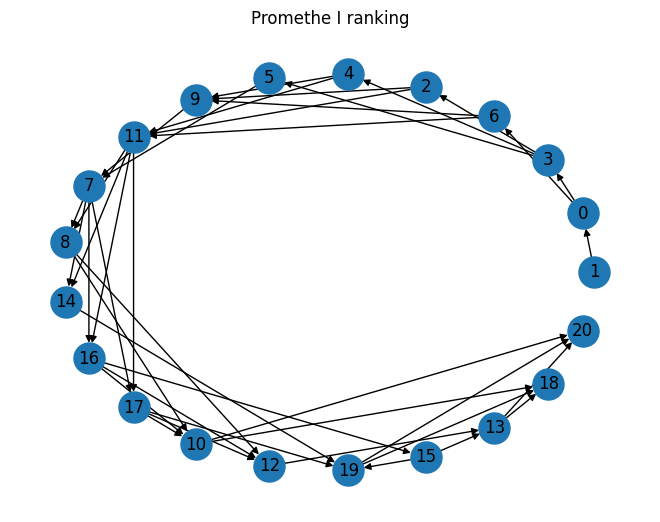

In [356]:
def draw_rank(rank_df, flow_df):
    G = nx.DiGraph()

    for i in flow_df.sort_values("flow", ascending=False).index.tolist():
        G.add_node(i)
        for j in range(len(rank_df)):
            if rank_df[j][i] == 'P' and (rank_df[j][rank_df.index[rank_df.loc[i]=='P']] == 'P').sum() == 0:
                G.add_edge(i, j)

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.title("Promethe I ranking")
    plt.show()


draw_rank(rank_df, flow_df)

### Promethe II

In [357]:
flow_df.sort_values("flow", ascending=False)

,Nazwa,flow+,flow-,flow
1,Nvidia RTX 3070,11.8320,5.0730,6.7590
0,Nvidia RTX 3060-Ti,10.9954,5.3070,5.6884
3,Nvidia GTX 1660S,10.6440,6.3472,4.2968
4,Nvidia RTX 3080,10.5650,6.7840,3.7810
2,Nvidia RTX 3050,10.0265,6.5896,3.4369
6,Nvidia RTX 2060,9.4590,6.1032,3.3558
5,Nvidia RTX 4090,10.6400,7.9720,2.6680
11,Nvidia RTX 3070-Ti,8.2400,7.0160,1.2240
9,Nvidia RTX 3090,9.1120,7.9050,1.2070
7,Nvidia RTX 4080,9.0810,8.3240,0.7570


# Electre

In [358]:
class electree:
    def __init__(self):
        self.ranking_descending = {}
        self.ranking_ascending = {}
        self.median_ranking = {}
        self.data = None
        self.nazwa = None
        self.c = None
        self.D = None
        self.C = None
        self.sigma = None
        self.rows = None
        self.cols = None

    def load_data(self, filepath):
        data = pd.read_csv(filepath, sep=';', skiprows=1)
        pd.set_option('display.max_rows', None)
        self.data = data.rename(columns={'Unnamed: 0': 'Nazwa'})
        self.nazwa = self.data['Nazwa']
        self.data.pop('Nazwa')
        self.rows = self.data.shape[0]
        self.cols = self.data.shape[1]

    def part_c(self, p, q):
        def cost_c(a, b, p, q):
            if a - b <= q:
                return 1
            elif a - b > p:
                return 0
            return (p - (a - b)) / (p - q)
        
        def gain_c(a, b, p, q):
            if a - b >= -q:
                return 1
            elif a - b < -p:
                return 0
            return (p - (b - a))  / (p - q)
        
        matrix = np.zeros((self.rows, self.rows, self.cols))
        for i, a in enumerate(self.data.values):
            for j, b in enumerate(self.data.values):
                if i == j:
                    matrix[i, j, :] = 1
                    continue
                for idx, criterion in enumerate(a):
                    if idx in (1, 3):
                        matrix[i, j, idx] = gain_c(criterion, b[idx], p[idx], q[idx])
                    else:
                        matrix[i, j, idx] = cost_c(criterion, b[idx], p[idx], q[idx])
        self.c = matrix
        
    def part_d(self, p, v):
        def gain_d(a, b, p, v):
            if a - b <= -v:
                return 1
            elif a - b >= -p:
                return 0
            return ((b - a) - p)  / (v - p)

        def cost_d(a, b, p, v):
            if a - b >= v:
                return 1
            elif a - b <= p:
                return 0
            return (v - (a - b)) / (v - p)

        matrix = np.zeros((self.rows, self.rows, self.cols))
        for i, a in enumerate(self.data.values):
            for j, b in enumerate(self.data.values):
                if i == j:
                    continue
                for idx, criterion in enumerate(a):
                    if idx in (1, 3):
                        if self.c[i, j, idx] == 0:
                            matrix[i, j, idx] = gain_d(criterion, b[idx], p[idx], v[idx])
                        else:
                            matrix[i, j, idx] = 0
                    else:
                        if self.c[i, j, idx] == 0:
                            matrix[i, j, idx] = cost_d(criterion, b[idx], p[idx], v[idx])
                        else:
                            matrix[i, j, idx] = 0
        self.D = matrix

    def full_c(self, w):
        weighted = self.c * w
        self.C =  np.sum(weighted, axis=2) / np.sum(w)
        
    def rank_credibility(self):
        matrix = np.zeros_like(self.C)
        for i in range(self.rows):
            for j in range(self.rows):
                f = np.where(self.D[i, j, :] > self.C[i, j])
                if len(f[0]) == 0:
                    matrix[i, j] = self.C[i, j]
                else:
                    if np.any(self.D[i, j, f] == 1):
                        matrix[i, j] = 0
                    else:
                        matrix[i, j] = self.C[i, j] * np.prod((1 - self.D[i, j, f]) / (1 - self.C[i, j]))
        self.sigma = matrix

    def destilation(self, descending):
        correction = lambda x: -0.15 * x + 0.3
        no = 1
        np.fill_diagonal(self.sigma, 0)

        matrix = self.sigma.copy()
        indices = np.arange(0, self.sigma.shape[0], dtype=int)
        matrix = np.c_[matrix, indices]
        
        while matrix.size:
            # znajdź próg wiarygodności
            lambda_up = np.max(matrix[:,:-1])

            # jeżeli jest równy 0 to kończę wykonywanie algorytmu
            if lambda_up == 0:
                self.ranking_descending[no] = matrix[:,-1]
                break

            # znajdź dolny próg
            lambda_down = np.max(matrix[:,:-1][np.where(matrix[:,:-1] < lambda_up - correction(lambda_up))])

            # zapisz sigme jezeli A > B
            c1 = (matrix[:,:-1] > lambda_down)
            c2 = (matrix[:,:-1] > matrix[:,:-1].T + correction(matrix[:,:-1]))
            without_last_col = matrix[:,:-1]
            current = np.where((c1) & (c2), without_last_col, 0)

            # siła, słabość
            strength = np.count_nonzero(current, axis=1)
            weakness = np.count_nonzero(current, axis=0)
            quality = strength - weakness

            # zapisuję indeksy najlepszych wariantów
            best_alternatives = np.where(quality == np.max(quality))[0] if descending else np.where(quality == np.min(quality))[0]
            idxs = np.array(matrix[best_alternatives, -1])
        
            # destylacja wewnętrzna
            while idxs.size != 1:
                initial_destilation = matrix[best_alternatives,:-1]
                initial_destilation = initial_destilation[:, best_alternatives]

                lambda_up = lambda_down

                if lambda_up == 0:
                    break
                    
                if np.where(initial_destilation < lambda_up - correction(lambda_up))[0].size != 0:
                    lambda_down = np.max(initial_destilation[np.where(initial_destilation < lambda_up - correction(lambda_up))])
                else:
                    lambda_down = 0

                c1 = (initial_destilation > lambda_down)
                c2 = (initial_destilation > initial_destilation.T + correction(initial_destilation))
                current = np.where((c1) & (c2), initial_destilation, 0)
                strength = np.count_nonzero(initial_destilation, axis=0)
                weakness = np.count_nonzero(initial_destilation, axis=1)
                quality = strength - weakness
                best_alternatives = np.where(quality == np.max(quality))[0] if descending else np.where(quality == np.min(quality))[0]
                
                idxs = idxs[best_alternatives]

            if descending:
                self.ranking_descending[no] = idxs
            else:
                self.ranking_ascending[no] = idxs
            
            for i in idxs:
                indices = indices[indices != i]
            
            for idx in idxs:
                row_to_delete = np.where(matrix[:,-1] == idx)[0]
                for i in range(2):
                    matrix = np.delete(matrix, row_to_delete, axis=i)
            no += 1

    def ranking(self):
        keys = list(self.ranking_descending.keys())
        values = list(self.ranking_descending.values())
        for k, v in zip(keys[::-1], values):
            self.ranking_descending[k] = v
    
        graph = {}
        asc_el = self.ranking_ascending.keys()
        desc_el = self.ranking_descending.keys()
        for el in range(self.rows):
            for i in desc_el:
                if el in self.ranking_descending[i]:
                    desc_path = i
                    break
            for i in asc_el:
                if el in self.ranking_ascending[i]:
                    asc_path = i
                    break
            if desc_path + asc_path not in graph.keys():
                graph[desc_path + asc_path] = [el]
            else:
                graph[desc_path + asc_path].append(el)            
        
        graph = dict(sorted(graph.items()))
        self.median_ranking = {k+1: v for k, v in zip(range(len(graph)), list(graph.values())[::-1])}

    def print_ranking(self, which_ranking):
            res = ''
            if which_ranking == 'median':
                print('Ranking medianowy')
                parts = []
                for k, ls in self.median_ranking.items():
                    names = [self.nazwa[i] for i in ls]
                    a = ', '.join([str(el) for el in names])
                    parts.append(a)
                for i, part in enumerate(parts):
                    res += f'{i+1}. {part}\n'
            if which_ranking == 'asc':
                print('Ranking wstępujący')
                parts = []
                for k, ls in self.ranking_ascending.items():
                    names = [self.nazwa[i] for i in ls]
                    a = ', '.join([str(el) for el in names])
                    parts.append(a)
                for i, part in enumerate(parts[::-1]):
                    res += f'{i+1}. {part}\n'
            if which_ranking == 'desc':
                print('Ranking zstępujący')
                parts = []
                for k, ls in self.ranking_descending.items():
                    names = [self.nazwa[i] for i in ls]
                    a = ', '.join([str(el) for el in names])
                    parts.append(a)
                for i, part in enumerate(parts[::-1]):
                    res += f'{i+1}. {part}\n'

            print(res)


In [359]:
p = [300, 40, 30, 30]
q = [100, 15, 10, 5]
v = [700, 50, 50, 50]
w = [3, 4, 1, 2]

electre = electree()
electre.load_data('GPUs.csv')
electre.part_c(p, q)
electre.part_d(p, v)
electre.full_c(w)
electre.rank_credibility()
electre.destilation(True)
electre.destilation(False)
electre.ranking()

electre.print_ranking('median')
electre.print_ranking('asc')
electre.print_ranking('desc')

Ranking medianowy
1. Nvidia RTX 3060-Ti, Nvidia RTX 3070
2. Nvidia GTX 1660S
3. Nvidia RTX 3080, Nvidia RTX 3070-Ti
4. Nvidia RTX 2060
5. Nvidia RTX 3090
6. Nvidia RTX 3050
7. Nvidia RTX 4080
8. Intel Arc A750, Nvidia RTX 3080-Ti
9. Nvidia RTX 4090, Nvidia RTX 3090-Ti, AMD RX 6700-XT
10. AMD RX 6900-XT, Intel Arc A770
11. AMD RX 6650-XT
12. AMD RX 6800
13. AMD RX 6800-XT
14. AMD RX 6750-XT
15. AMD RX 6950-XT

Ranking wstępujący
1. Nvidia RTX 3060-Ti, Nvidia RTX 3070, Nvidia GTX 1660S, Nvidia RTX 3080, Nvidia RTX 4090, Nvidia RTX 3090-Ti
2. Nvidia RTX 4080
3. Nvidia RTX 3090
4. Nvidia RTX 3050, Nvidia RTX 2060, Nvidia RTX 3070-Ti
5. Nvidia RTX 3080-Ti
6. AMD RX 6900-XT
7. AMD RX 6700-XT
8. Intel Arc A750
9. AMD RX 6800
10. AMD RX 6800-XT, Intel Arc A770
11. AMD RX 6650-XT
12. AMD RX 6750-XT, AMD RX 6950-XT

Ranking zstępujący
1. Nvidia RTX 3060-Ti, Nvidia RTX 3070
2. Nvidia RTX 3070-Ti
3. Nvidia GTX 1660S
4. Nvidia RTX 2060
5. Nvidia RTX 3080
6. Nvidia RTX 3050, Nvidia RTX 3090
7. Intel